# Monte Carlo Methods
Cet algorithme calcule une valeur précise du rendement attendu pour  Q  pour chaque état s et action a

Il donne en fait une estimation moyenne de la valeur  Q  de la politique pour chaque couple état-action

Monte Carlo methods require only experience—sample sequences of states, actions, and rewards from actual or simulated interaction with an environment. Learning from actual experience is striking because it requires no prior knowledge of the environment’s dynamics, yet can still attain optimal behavior. Learning from simulated experience is also powerful. Although a model is required, the model need only generate sample transitions, not the complete probability distributions of all possible transitions that is required for dynamic programming (DP). In surprisingly many cases it is easy to generate experience sampled according to the desired probability distributions, but infeasible to obtain the distributions in explicit form.
Monte Carlo methods are ways of solving the reinforcement learning problem based on averagingsample returns. To ensure that well-defined returns are available, here we define Monte Carlo methods only for episodic tasks. That is, we assume experience is divided into episodes, and that all episodes
eventually terminate no matter what actions are selected. Only on the completion of an episode are value estimates and policies changed. Monte Carlo methods can thus be incremental in an episode-byepisode sense, but not in a step-by-step (online) sense. 

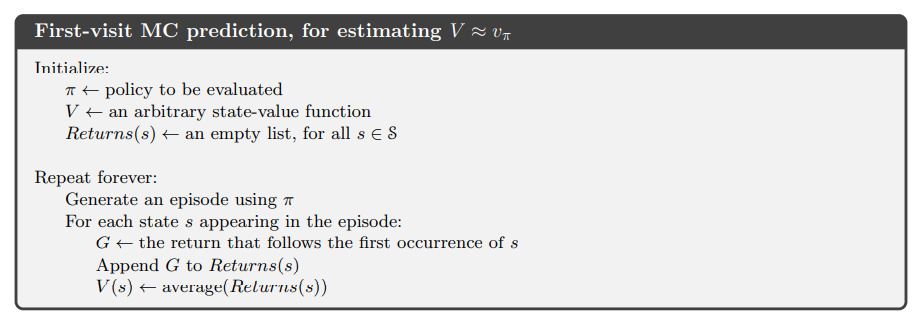

Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount (γ = 1); therefore these terminal rewards are also the
returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he
could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be  made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 states.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits. To find the statevalue function for this policy by a Monte Carlo approach, one simulates many blackjack games using the policy and averages the returns following each state. Note that in this task the same state never
recurs within one episode, so there is no difference between first-visit and every-visit MC methods. In this way, we obtained the estimates of the state-value function shown in Figure 5.1. The estimates for states with a usable ace are less certain and less regular because these states are less common. In any event, after 500,000 games the value function is very well approximated.

Although we have complete knowledge of the environment in this task, it would not be easy to apply DP methods to compute the value function. DP methods require the distribution of next events—in particular, they require the environments dynamics as given by the four-argument function p—and
it is not easy to determine this for blackjack. For example, suppose the player’s sum is 14 and he chooses to stick. What is his probability of terminating with with a reward of +1 as a function of the
dealer’s showing card? All of the probabilities must be computed before DP can be applied, and such computations are often complex and error-prone. In contrast, generating the sample games required by Monte Carlo methods is easy. This is the case surprisingly often; the ability of Monte Carlo methods to work with sample episodes alone can be a significant advantage even when one has complete knowledge of the environment’s dynamics.

In [9]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [6]:
## source : https://github.com/lukysummer/OpenAI-Monte-Carlo-Control-for-Blackjack/blob/master/plot_utils.py
  
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [7]:
env = gym.make('Blackjack-v0')

In [10]:
## source : http://www.pabloruizruiz10.com/resources/RL/Exercises/5.-MonteCarlo/5.2_Monte_Carlo_Control_Blackjack_Game.html

def mc_control(env, num_episodes, alpha, gamma=0.9, eps0=1.0, eps_decay=.99999, eps_min=0.05):
    
    # Variable to store all the possible actions of the environment
    nA = env.action_space.n
    
    # Initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Initialize epsilon
    eps = eps0
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Recalculate epsilon with a scheduler (a simple decay)
        eps = max(eps*eps_decay, eps_min)
        
        # Run the episode by following the eps-greedy policy
        episode = generate_episode_from_Q(env, Q, eps, nA)
        
        # Update the Q-Table values
        Q = update_Q(env, episode, Q, alpha, gamma)
    
    # Unroll our Q-Table picking the best action at each state (row) to define the found optimal policy
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

def generate_episode_from_Q(env, Q, eps, nA):
    '''
    Function to generate a MC episode given the environment, the last Q-Table,
    the ratio of exploration and the total number of actions
    Returns: and episode as a 3-tuple of (states, actions, rewards)
    '''
    # Initialize an empty env to run the new episode
    episode = []
    state = env.reset()
    
    # Until terminal state
    while True:
        
        # Generate an action following the policy
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], eps, nA)) if state in Q else env.action_space.sample()
        
        # Perform the 3-tuple for that state - Every visit approach
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        
        # Advance one state 
        state = next_state
        if done:
            break
    
    return episode

def get_probs(Qs, eps, nA):
    '''
    Function that obtains the probabilites corresponding to e-greedy policy
    '''
    # 1 - Initial equal radom probability for every possible action
    policy_s = np.ones(nA) * eps / nA
    
    # 2 - Determine which is the current optimal action for that state
    best_a = np.argmax(Qs)
    
    # 3 - Update (increase) the probability for the optimal action
    policy_s[best_a] = 1 - eps + (eps / nA)
    
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    '''
    Function to update the Q-Table after running 1 episode
    '''
    # 1 - Extract the information of the run episode
    states, actions, rewards = zip(*episode)
    
    # 2 - Apply the discount factor
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # 3 - Apply the update function to every Q(s,a) <- Q(s,a) + alpha*[Gt - Q(s,a)]
    for i, s in enumerate(states):
        
        a = actions[i]
        old_Q = Q[s][a]
        Q[s][a] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [11]:
# The value for alpha and the number of episodes have been set after trial and error
policy, Q = mc_control(env, 1000000, 0.1)

Episode 1000000/1000000.

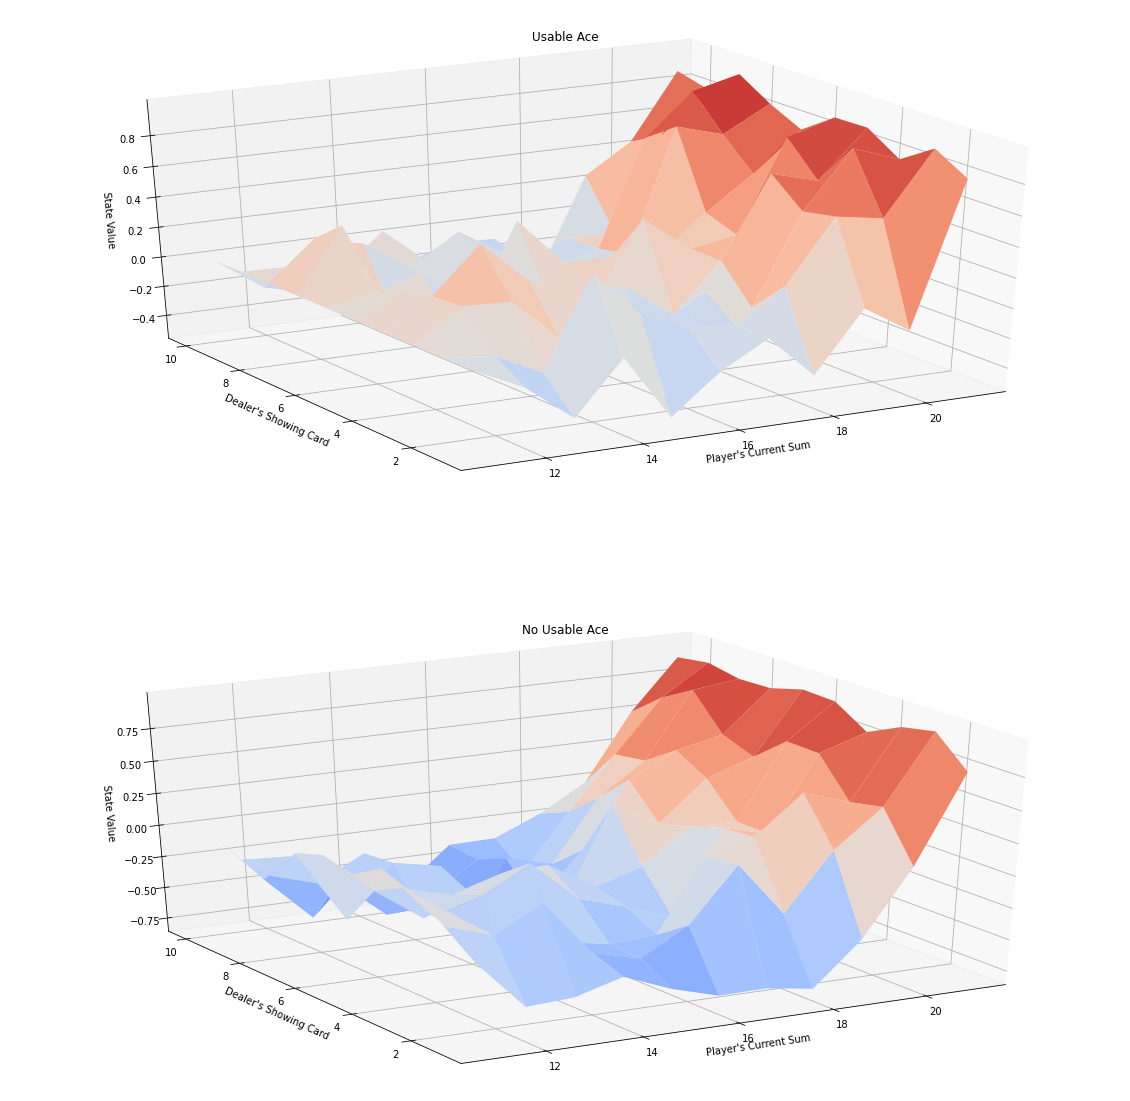

In [12]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)


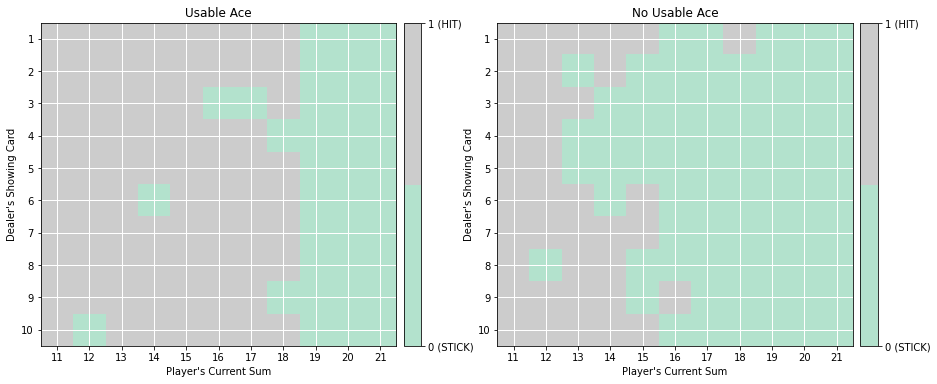

In [13]:
plot_policy(policy)